<a href="https://colab.research.google.com/github/fryall/fofo/blob/main/Copy_of_Untitled3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm # import was correct
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D,GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten, Dense, InputLayer

<ipython-input-1-9b49285444bd>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm # import was correct


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
image_size=[224,224]
input_folder = '/content/drive/MyDrive/try1'
splitfolders.ratio(input_folder, output="twenty",
                   seed=42, ratio=(.7, .3 ),
                   group_prefix=None)

Copying files: 6271 files [02:28, 42.37 files/s] 


In [ ]:
import tensorflow as tf

# Define the paths to the train and validation directories
train_dir = 'twenty/train'
val_dir = 'twenty/val'

# Load the training data
train_path = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),  # same as your image_size
    batch_size=32,          # adjust this as needed
    label_mode='categorical'  # or 'binary' depending on your labels
)

# Load the validation data
test_path= tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),  # same as your image_size
    batch_size=32,          # adjust this as needed
    label_mode='categorical'  # or 'binary' depending on your labels
)

Found 4380 files belonging to 20 classes.
Found 1889 files belonging to 20 classes.


In [ ]:
from keras.applications import VGG16
VGG=VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
VGG.trainable=False

In [ ]:
input_shape = (224, 224, 3)

In [ ]:
model=Sequential()
model.add(InputLayer(shape=input_shape))
model.add(VGG)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=512,activation="relu"))
model.add(Dense(units=256,activation="relu"))
model.add(Dense(units=20,activation="softmax"))

In [ ]:
print(VGG.output_shape)

(None, 7, 7, 512)


In [ ]:
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,113,812 (57.65 MB)

 Trainable params: 399,124 (1.52 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98):
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg16_1.keras", monitor="val_accuracy", verbose=1,
                             save_best_only=True, save_weights_only=False)
# Removed 'early' parameter as it's not part of ModelCheckpoint

early_stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=40,
                               verbose=1, mode='auto')
# Created a separate EarlyStopping callback

In [ ]:
history = model.fit(x=train_path, steps_per_epoch=136, epochs=10,
                 validation_data=test_path, validation_steps=1,
                 callbacks=[checkpoint])

Epoch 1/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.3467 - loss: 3.5981 
Epoch 1: val_accuracy improved from -inf to 0.71875, saving model to vgg16_1.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 2898s 21s/step - accuracy: 0.3477 - loss: 3.5879 - val_accuracy: 0.7188 - val_loss: 0.9961
Epoch 2/10
  1/136 ━━━━━━━━━━━━━━━━━━━━ 40:33 18s/step - accuracy: 0.5357 - loss: 1.4644
Epoch 2: val_accuracy did not improve from 0.71875
136/136 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - accuracy: 0.5357 - loss: 1.4644 - val_accuracy: 0.6562 - val_loss: 1.1934
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.7062 - loss: 0.9769 
Epoch 3: val_accuracy improved from 0.71875 to 0.75000, saving model to vgg16_1.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 2920s 21s/step - accuracy: 0.7063 - loss: 0.9765 - val_accuracy: 0.7500 - val_loss: 0.9131
Epoch 4/10
  1/136 ━━━━━━━━━━━━━━━━━━━━ 39:39 18s/step - accuracy: 0.6786 - loss: 0.9516
Epoch 4: val_accuracy did not improve from 0.75000
136/136 ━━━━━━━━━

In [ ]:
batch_size = 32
steps_per_epoch = 137
validation_steps = 60

history = model.fit(
    x=train_path,
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    validation_data=test_path,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping]
)

KeyboardInterrupt: 

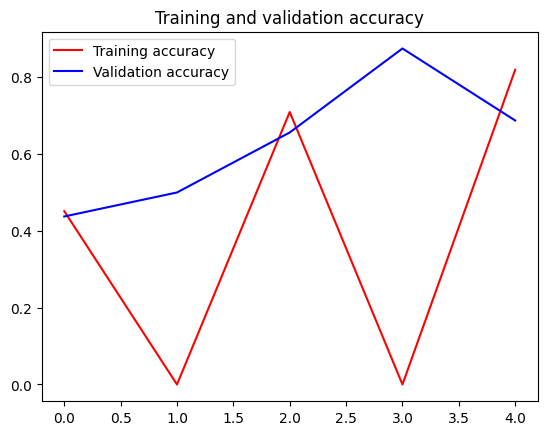

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

60/60 ━━━━━━━━━━━━━━━━━━━━ 1230s 20s/step


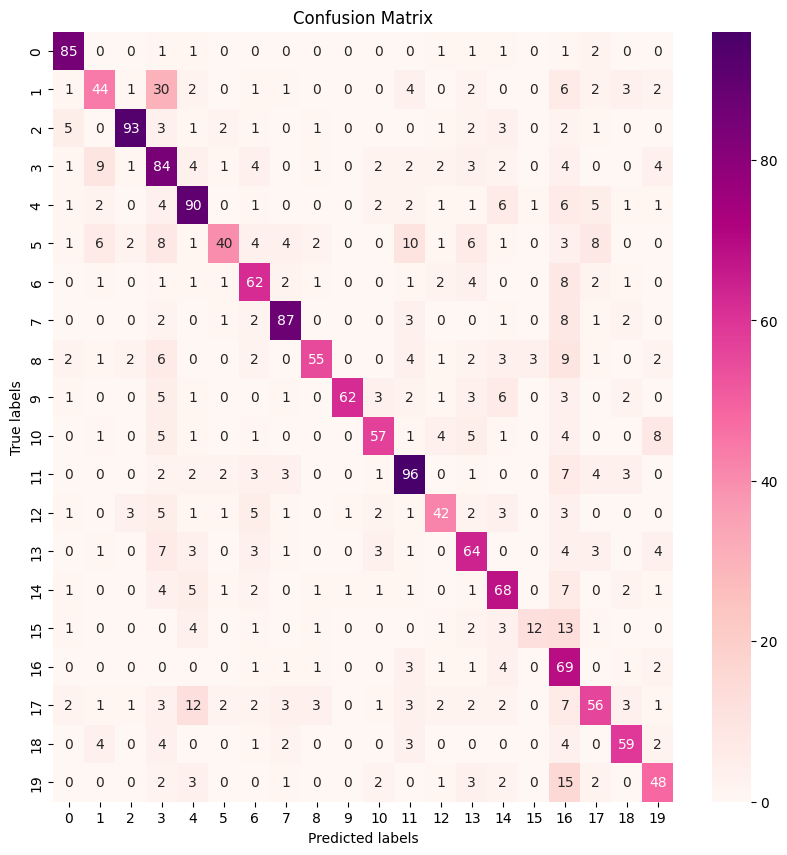

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a trained model 'model' and test dataset 'test_path'
# Extract all test images and labels into numpy arrays
X_test = []
y_test = []
for images, labels in test_path:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())

# Concatenate the batches into a single numpy array
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

# Predict labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='RdPu')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, F1 score, and accuracy
report = classification_report(y_true_classes, y_pred_classes, output_dict=True)
accuracy = report['accuracy']
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

# Display the calculated metrics
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print the test accuracy
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Validation Accuracy: 0.6739
Precision: 0.7075
Recall: 0.6602
F1 Score: 0.6670
Test Accuracy: 67.39%


In [ ]:
# Save the entire model to a HDF5 file
model.save("my_model.h5")

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpjsddi80_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_19')
Output Type:
  TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)
Captures:
  137294737845488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294737842848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294737847952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294737844784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294738244352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294738247344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294738247696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294738249984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294738251216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137294738253856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1372947382

In [ ]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Assuming 'train_path' is your training dataset
class_names = train_path.class_names

# Save the class names to a text file
with open('labels.txt', 'w') as f:
  for class_name in class_names:
    f.write(class_name + '\n')

In [ ]:
from google.colab import files

files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>